<a href="https://colab.research.google.com/github/Rijan-Joshi/Fun-Learning/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [347]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [348]:
g = np.arange(-5,5,0.25)
g

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [349]:
def f(x):
  return 3*x**2 - 2*x + 5

In [350]:
f(3)

26

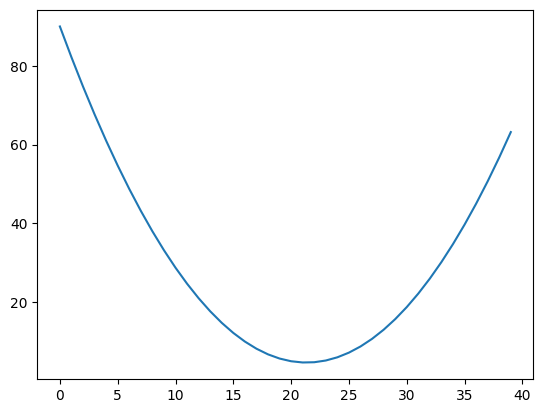

In [351]:
f_g = f(g)
plt.plot(f_g)

In [352]:
h = 0.0001
a = 3
(f(a+h) - f(a))/h #Rough Estimation of derivative

16.000300000058587

In [353]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("Slope", (d2 - d1)/h)


d1 4
d2 4.0002
Slope 2.0000000000042206


In [354]:
#Value Data Structure for Micrograd

class Value:

  def __init__(self, data, _children = (), _op = "", label = ""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return  f"Value(data = {self.data})"

  def __add__(self, other):
    out  = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad +=  (1 - t**2) * out.grad

    out._backward = _backward
    return out


  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()


In [355]:
# a = Value(2, label = 'a')
# b = Value(-3); b.label = 'b'
# c = Value(5); c.label = 'c'

# i = a * b; i.label = 'i'
# d = i + c; d.label = 'd'

# f = Value(-2, label = 'f')
# L = d * f; L.label = 'L'
# L

In [363]:
#Visualizing the graph for forward pass
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format ='svg', graph_attr = {'rankdir':'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [364]:
#Simple nn

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
b = Value(6.8813735870195432, label = 'b')
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [365]:
o.backward()

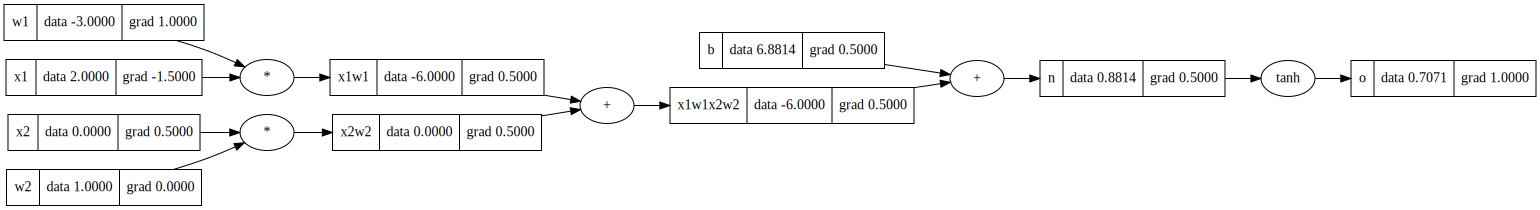

In [366]:
draw_dot(o)

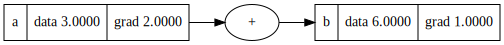

In [367]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)